# CS6120
# Lab 3 - PyTorch Intro & Recurrent Neural Networks
A subset of the MATH60629A tutorial at the University of Toronto by *Oleksiy Ostapenko*

(Author's original sources: [Deep Learning Book](https://www.deeplearningbook.org/), [Christophe Olah's Blog](http://colah.github.io/), RNNs [tutorial](https://colab.research.google.com/drive/1jR_DGoVDcxZ104onxTk2C7YeV7vTt1DV#scrollTo=dRNYHWwYyd4Q) by Yen-Ling Kuo and Eugenio Piasini)

In this practical session, we will explore how to model sequential data using recurrent neural networks (RNNs). In the first part, we will build an intuition on some moving parts of RNNs on a toy problem. The second part of the tutorial will showcase an example of applying RNNs to a more realistic dataset of textual data.

Here we will use [Pytorch](https://colab.research.google.com/drive/1y9raF4S_HM3XU8e6es5j_l0WerKTQJeu#scrollTo=9OpW6mo6Nwgy&line=1&uniqifier=1) library, which is a popular open-source library that provides many convenient tools for building artificial neural networks.

# Part 1: simple example (learning a sine wave)

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math
import numpy as np
torch.manual_seed(235)
np.random.seed(235)

%matplotlib inline
import matplotlib.pyplot as plt

Let's first generating some data!

In [30]:
def generate_sinus_wave(train_len, valid_len):
    time_steps = np.linspace(0, 8*np.pi, train_len+valid_len)
    data = np.sin(time_steps)

    xs = data[:train_len-1]
    ys = data[1:train_len] # targets are shifted by 1 step, since we're predicting the next step based on history

    train_x = torch.Tensor(xs).view(-1, 1,1)
    train_y = torch.Tensor(ys)
    return data, time_steps, train_x, train_y

In [32]:
print(len(data))
#print(time_steps)
print(train_x) 
print(train_y)

200
tensor([[[0.0000]],

        [[0.1260]],

        [[0.2499]],

        [[0.3699]],

        [[0.4840]],

        [[0.5903]],

        [[0.6873]],

        [[0.7733]],

        [[0.8470]],

        [[0.9072]],

        [[0.9530]],

        [[0.9836]],

        [[0.9985]],

        [[0.9975]],

        [[0.9806]],

        [[0.9481]],

        [[0.9005]],

        [[0.8385]],

        [[0.7632]]])
tensor([0.1260, 0.2499, 0.3699, 0.4840, 0.5903, 0.6873, 0.7733, 0.8470, 0.9072,
        0.9530, 0.9836, 0.9985, 0.9975, 0.9806, 0.9481, 0.9005, 0.8385, 0.7632,
        0.6758])


[ 0.00000000e+00  1.25959705e-01  2.49912962e-01  3.69885285e-01
  4.83965601e-01  5.90336692e-01  6.87304143e-01  7.73323331e-01
  8.47024034e-01  9.07232251e-01  9.52988909e-01  9.83565137e-01
  9.98473878e-01  9.97477646e-01  9.80592311e-01  9.48086844e-01
  9.00479032e-01  8.38527236e-01  7.63218303e-01  6.75751849e-01
  5.77521152e-01  4.70090958e-01  3.55172553e-01  2.34596503e-01
  1.10283499e-01 -1.57862420e-02 -1.41604519e-01 -2.65167138e-01
 -3.84505835e-01 -4.97719629e-01 -6.03005107e-01 -6.98685146e-01
 -7.83235632e-01 -8.55309735e-01 -9.13759368e-01 -9.57653470e-01
 -9.86292838e-01 -9.99221269e-01 -9.96232822e-01 -9.77375101e-01
 -9.42948495e-01 -8.93501396e-01 -8.29821460e-01 -7.52923064e-01
 -6.64031143e-01 -5.64561683e-01 -4.56099159e-01 -3.40371303e-01
 -2.19221577e-01 -9.45798078e-02  3.15685498e-02  1.57214043e-01
  2.80355229e-01  3.99030558e-01  5.11349616e-01  6.15523241e-01
  7.09892022e-01  7.92952733e-01  8.63382275e-01  9.20058757e-01
  9.62079363e-01  9.88774

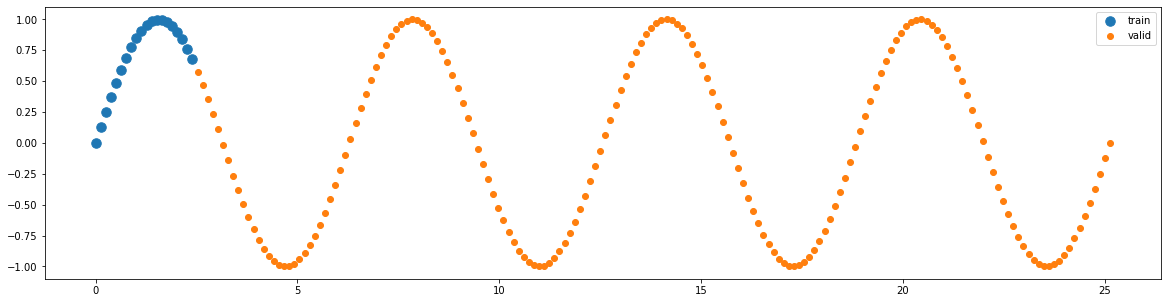

In [31]:
seq_length = 200 #total sequence length
portion_train =0.1 #portion of the sequence length used for training

train_len = int(seq_length*portion_train)
valid_len = seq_length-train_len
data, time_steps, train_x, train_y = \
    generate_sinus_wave(train_len = train_len, valid_len = valid_len)
print(data, time_steps)
#plot our data
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len], data[:train_len], s=90, label='train')
plt.scatter(time_steps[train_len:], data[train_len:], label='valid')
ax.legend()

We formulate the task as predicting the point at time step $t+1$ given the sequence of previous inputs up until time step $t$. We, therefore, need to shift our targets by one as mentioned in the class. Let's have a closer look at our input and target data again **(note: targets are shifted by 1)**.

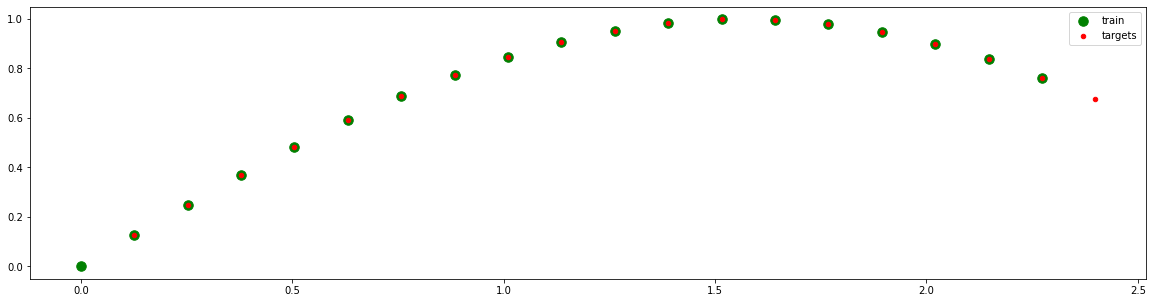

In [33]:
#plot our data
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len-1], train_x, s=90, c='g', label='train')
plt.scatter(time_steps[1:train_len], train_y, s=20, c='r', label='targets')
ax.legend()

We will use data generated from a sine curve for our toy sequential prediction problem. Namely, given some part of the sequence as training data (blue points in the visualization above), our model will be tasked to generate the rest of the sequence (orange points).

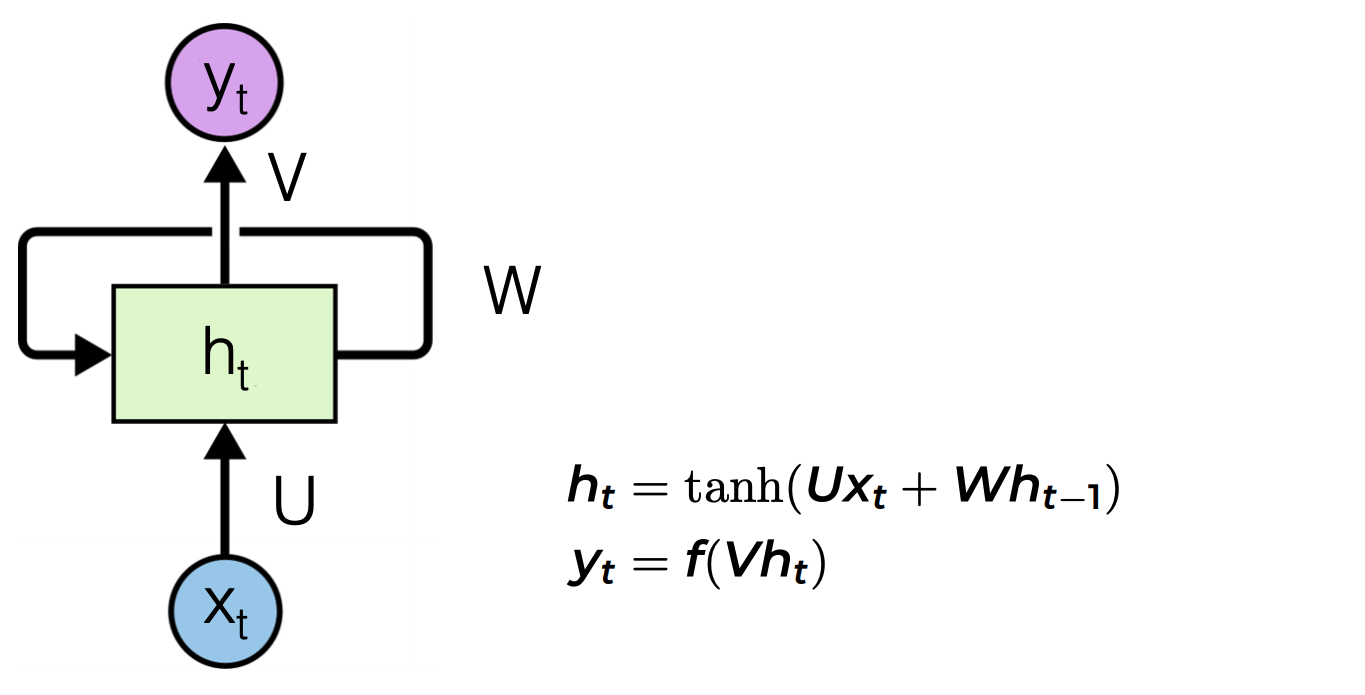
Image source http://colah.github.io/

As we have seen in the class, a simple recurrent network cell takes the current input at $X_t$ and produces an output ($y_t$) and a new hidden state that is passed through a recurrent connection to the next time step (in the figure above the recurrent connection uses weights W).

Let's first implement this simple RNN cell using Pytorch operations. Note, we use the $sigmoid$ activation (covered in the previous lab and lectures).

As you might recall from the previous lecture on feed-forward neural networks, the second equation in the figure above ($y_t = f(Vh_t)$) looks very similar to the feedforward layer. Indeed it is one, where $V$ denotes our learnable weights and $f$ is our activation function. Pytorch already provides us with an implementation of such a layer. We will add it outside of our simple RNN cell for convenience.


In [34]:
class RNN_Cell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN_Cell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # randomly initialize our trainable parameters
        ''' YOUR CODE HERE '''
        self.W = nn.Parameter(torch.randn(input_size, hidden_size))
        self.U = nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.b = nn.Parameter(torch.zeros(hidden_size))
    
    def forward(self, x_t, state):

        h_prev = state

        ''' YOUR CODE HERE '''
        h = torch.matmul(x_t, self.W) + torch.matmul(h_prev, self.U) + self.b
        h = torch.sigmoid(h)

        return h

Now, having implemented our simple recurrent cell, we need to put cells together to form a network.

Remember the principle of RNNs? The same(!) cell is used repeatedly receiving the new $X_t$ and the previous hidden state as input.

 We will also add our missing feed-forward layer (equation $y_t = f(Vh_t)$) here (we will set $f$ to identity, since we do not need any additional activation function here).

In [35]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        ''' YOUR CODE HERE '''
        self.rnn_cell = RNN_Cell(input_dim, hidden_size)
        

    def init_hidden(self,):
        # we will initialize our hidden state with zeros
        return torch.zeros(1, self.hidden_size)

    def forward(self, X, h=None):
        
        ''' YOUR CODE HERE '''
        batch_size = X.size(0)
        seq_length = X.size(1)

        # Initialize hidden state
        if h is None:
            h = self.init_hidden()
        else:
            h = h.detach()  # detach to avoid backprop through initial hidden state

        outputs = []

        # Iterate through time steps
        for t in range(seq_length):
            # Get input at time step t
            x_t = X[:, t,:]

            # Update hidden state using RNN cell
            h = self.rnn_cell(x_t, h)

            # Append output
            outputs.append(h)

        return torch.stack(outputs), h

        #return torch.stack(outputs), self.h

**Question 1 (RNNs)** : in the standard feed-forward neural network, all the training and test samples are considered independently. Can you explain how this can be a bad fit for sequential data modeling like the stock market or sequential sine curve fitting?

**Question 2 (RNNs)**: given your answers to the previous question, can you explain in your own words, which role the hidden state ($h$) plays in RNNs?


**YOUR ANSWERS HERE**

Okay, we have implemented the 'forward path' of our RNN model. But what about the actual learning. The learning algorithm that is usually used to train RNNs is called [backpropagation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time). Don't be afraid of the fancy name(!), the essential idea that underlines this and many other learning algorithms for the deep neural network is just repeatedly applying the chain rule of differentiation:

if $F = f(y), y = g(x)$, we have that $ \frac{dF}{dx} = \frac{dF}{dy} \frac{dy}{dx}  $ (given f and g are differentiable functions).

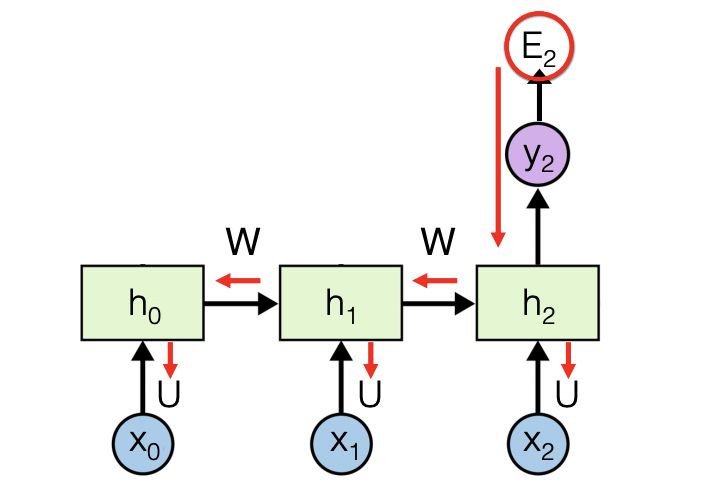
Image source http://colah.github.io/

The above image depicts a simple RNN with 3 states. Let's put it into mathematical equations ignoring the activation functions (and assuming our learnable weights are just scalars).

$h_o = U x_0$

$h_1 = U x_1 + W h_0$

$h_2 = U x_2 + W h_1$

Suppose we are dealing with a regression problem, let's include a simple L2 loss:

$E = \frac{1}{2} (h_2 - y)^2 $, where $y$ is the ground truth.

**Question 3 RNNs** : write down equations for the backpropagation through time for states $h_0$, $h_1$ and $h_2$ (hint: simply use the chain rule starting from the error term).

**YOUR ANSWER HERE**

Don't worry, we are not going to code the backpropagation equations by hand this time, Pytorch will do the tedious work of differentiation for us.

Finally, let's now train our simple RNN on the input sequence generated previously.

In [38]:
hidden_size = 19
learning_rate = 0.01
# feel free to experiment with these

In [39]:
model = RNN(1,hidden_size) # first we instantiate our model

# set up model training below by looking up PyTorch documentation
# Run 300 epochs using the Adam optimizer

''' YOUR CODE HERE '''
# Define loss function
criterion = nn.MSELoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Number of epochs
num_epochs = 300

# Training loop
for epoch in range(num_epochs):
    # Set model to training mode
    #model.train()
    # Clear gradients
    optimizer.zero_grad()

    # Forward pass
    outputs, _ = model(train_x)

    # Compute loss
    loss = criterion(outputs, train_y)

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()
    
    """
    # Iterate over the dataset
    for inputs, targets in dataloader:  # assuming you have a dataloader set up
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs, _ = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
    """
    
    # Print epoch loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training complete.")

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([1, 19, 19])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/300], Loss: 0.1436
Epoch [2/300], Loss: 0.1411
Epoch [3/300], Loss: 0.1386
Epoch [4/300], Loss: 0.1361
Epoch [5/300], Loss: 0.1336
Epoch [6/300], Loss: 0.1312
Epoch [7/300], Loss: 0.1288
Epoch [8/300], Loss: 0.1264
Epoch [9/300], Loss: 0.1241
Epoch [10/300], Loss: 0.1218
Epoch [11/300], Loss: 0.1195
Epoch [12/300], Loss: 0.1172
Epoch [13/300], Loss: 0.1150
Epoch [14/300], Loss: 0.1128
Epoch [15/300], Loss: 0.1107
Epoch [16/300], Loss: 0.1085
Epoch [17/300], Loss: 0.1064
Epoch [18/300], Loss: 0.1044
Epoch [19/300], Loss: 0.1023
Epoch [20/300], Loss: 0.1003
Epoch [21/300], Loss: 0.0983
Epoch [22/300], Loss: 0.0964
Epoch [23/300], Loss: 0.0945
Epoch [24/300], Loss: 0.0926
Epoch [25/300], Loss: 0.0907
Epoch [26/300], Loss: 0.0889
Epoch [27/300], Loss: 0.0871
Epoch [28/300], Loss: 0.0854
Epoch [29/300], Loss: 0.0836
Epoch [30/300], Loss: 0.0819
Epoch [31/300], Loss: 0.0803
Epoch [32/300], Loss: 0.0786
Epoch [33/300], Loss: 0.0770
Epoch [34/300], Loss: 0.0754
Epoch [35/300], Loss: 0

Let's see how our trained model can predict the training labels. Given a point from our training data (time $t$), we will ask our model to generate the next point ($t+1$), one point at a time. We will carry over the hidden state along the sequence generation.

train_x.shape torch.Size([19, 1, 1]) 19
input = train_x[ 0 ] :  tensor([[0.]])
input = input.view(1, 1, 1) tensor([[[0.]]])
pred, hidden_prev 1 tensor([[0.2454, 0.3146, 0.3724, 0.4922, 0.5903, 0.6844, 0.7421, 0.7733, 0.7724,
         0.7927, 0.8004, 0.8284, 0.8154, 0.8047, 0.8152, 0.7696, 0.7434, 0.7543,
         0.6521]], grad_fn=<SigmoidBackward0>)
predictions.append(pred.data.numpy()[0][0]) [array([0.24540335, 0.31455106, 0.37238452, 0.4921796 , 0.59033716,
       0.6843637 , 0.74205965, 0.7733216 , 0.7723734 , 0.79268086,
       0.8003877 , 0.82842565, 0.8153818 , 0.8047115 , 0.81523234,
       0.76961005, 0.7433898 , 0.7542907 , 0.6521371 ], dtype=float32)]
input = train_x[ 1 ] :  tensor([[0.1260]])
input = input.view(1, 1, 1) tensor([[[0.1260]]])
pred, hidden_prev 1 tensor([[0.0069, 0.3398, 0.0033, 0.9904, 0.1128, 0.9587, 0.0781, 0.6878, 0.9300,
         0.8266, 0.0990, 0.9876, 0.5186, 0.9004, 0.1659, 0.7869, 0.9964, 0.0057,
         0.1061]], grad_fn=<SigmoidBackward0>)
predicti

ValueError: x and y must be the same size

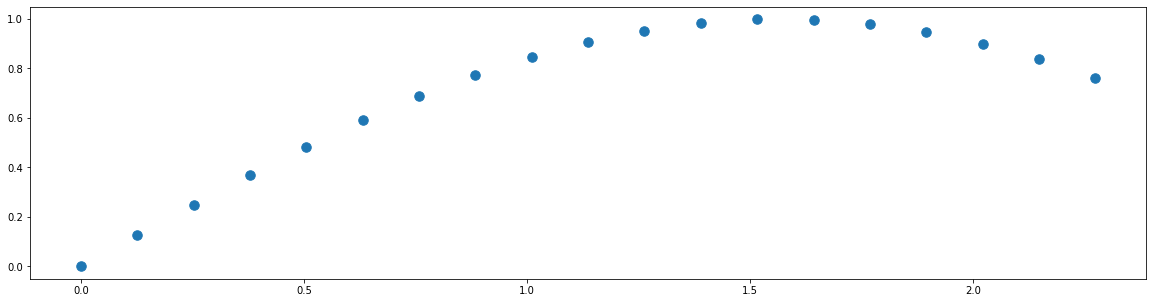

In [52]:
def make_predictions_train(model):
    predictions = []
    hidden_prev = None
    # we will go over all points in out training sequence
    print('train_x.shape',train_x.shape,train_x.shape[0])
    for i in range(train_x.shape[0]):
        input = train_x[i]
        print('input = train_x[',i,'] : ', input)
        input = input.view(1, 1, 1)
        print('input = input.view(1, 1, 1)', input)

        # we will give the current (single) point and the (current)
        # hidden state as input to our model

        # we carry over the previous hidden state
        pred, hidden_prev = model(input, hidden_prev)
        print('pred, hidden_prev',pred.size(0), hidden_prev)
        predictions.append(pred.data.numpy()[0][0])
        print('predictions.append(pred.data.numpy()[0][0])', predictions)
    print('predictions : ',predictions)#, predictions.size)
    print('hidden_prev : ', hidden_prev)
    return predictions, hidden_prev

predictions_train, hidden_prev = make_predictions_train(model)
print('time_steps[1:train_len] : ', time_steps[1:train_len])#, time_steps[1:train_len].size)
#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len-1], data[:train_len-1], s=90, label='actual')
print(time_steps[:train_len-1].size, data[:train_len-1].size)
plt.scatter(time_steps[1:train_len], predictions_train, label='predicted')
ax.legend()

As we can see in the plot above, that our model has learned to fit the training part of the sequence almost perfectly.

But what about the unseen part of the sequence?

In [41]:
def generate_unseen_sequence(model, length, starting_point, hidden_state):
    predicts=[]
    input = torch.Tensor(starting_point).view(1,1,1)
    for i in range(length):
        pred, hidden_state = model(input, hidden_state)
        predicts.append(pred.data.numpy()[0][0])
        input = pred
    return predicts


Let's generate the part of the sequence which was hidden from the model at training. Note, from the model's perspective, it is like generating completely new unseen data. If our data were e.g. text instead of a simple sine wave, we could ask our model to generate a completely new text, isn't that cool?

Note, to generate the unseen part of the sequence:
- we will first condition on the last point from the seen sequence, and ask the model to generate a new point
- then we will pass this newly generated point and the new hidden state as input to out model
- the model will then generate a new point conditioned on a point previously generated by the model
- In theory we could generate an infinitely long sequence on new data in this way.

In [42]:
generated_points = generate_unseen_sequence(model, valid_len, starting_point=predictions_train[-1], hidden_state=hidden_prev)

predictions = predictions_train+generated_points #concatenate two lists

#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps, data, s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions[:train_len-1], label='predicted')
plt.scatter(time_steps[train_len:], predictions[train_len-1:], label='generated')
ax.legend()

RuntimeError: shape '[1, 1, 1]' is invalid for input of size 19

As can be seen in the plot above, our model's performance is quite poor when it comes to generating the unseen part of the sequence (shown in green).

Looking at our training sequence (the orange part in the plot above), does it actually contain the information needed to be able to capture the periodic nature of the sine wave? Well, even as a human, if you had never seen a sine wave before, you probably would not be able to learn what a sine wave is solely from observing half of the period length of a sine wave (you would probably think it's just a parabola).

**Question 4 (RNNs)**: try increasing the training sequence length ($portion\_train$) in the code snippet below. (Hint: set the training length such that it includes at least one complete cycle of the sine wave.)

In [ ]:

portion_train = 0.1 # change this parameter to try out a longer training sequence to cover at least one period

train_len = int(seq_length*portion_train)
valid_len = seq_length-train_len

data, time_steps, train_x, train_y = generate_sinus_wave(train_len = train_len, valid_len = valid_len)

fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps[:train_len], data[:train_len], s=90, label='train')
plt.scatter(time_steps[train_len:], data[train_len:], label='valid')
ax.legend()

Let's train our model again, for a bit longer this time and see the result.

In [ ]:
model = RNN(1,hidden_size)
optimizer = optim.Adam(model.parameters(), learning_rate)
epochs = 500 #
for epoch in range(epochs):
    optimizer.zero_grad()
    output, _ = model(train_x)
    loss = criterion(output.view(-1), train_y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("Epoch {}: loss {}".format(epoch, loss.item()))

In [ ]:
#get training data predictions
predictions_train, hidden_prev = make_predictions_train(model)
#generate unsee points
generated_points = generate_unseen_sequence(model, valid_len,
                                            starting_point=predictions_train[-1],
                                            hidden_state=hidden_prev)
#concatenate two lists
predictions = predictions_train+generated_points
#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps, data, s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions[:train_len-1], label='predicted')
plt.scatter(time_steps[train_len:], predictions[train_len-1:], label='generated')
ax.legend()

And voilà, our new model is somewhat better in capturing the periodic nature of the sine wave.

Note, if you rerun the training procedure for several times you will observe that each time you get a different result. This is due to the random reinitialization of the trainable weight in our RNN cell each time you restart training (re-instantiate the network object):

```
self.U = torch.nn.Parameter(torch.randn(input_size, hidden_size))

self.W = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
```


We certainly could try to get some better results by either:
- further hyperparameter tuning
- further increasing the length of the training sequence (MORE DATA is always good)

These are valid strategies often used in deep learning to improve the performance of the models. Yet, many times the real innovations come from improving the actual learning algorithms.